# Learning Building Thermal Dynamics using Neural State Space Models in NeuroMANCER  


This tutorial demonstrates the use of [Neural State Space Models](https://ieeexplore.ieee.org/abstract/document/9482930) (NSSMs)  for system identificaiton of building thermal dynamics. 
NSSMs are an extension of disctete-time linear [State Space Models](https://en.wikipedia.org/wiki/State-space_representation) (SSM) that have been traditionally used in control engineering for decades. Linear SSMs have the form $x_{k+1} = A x_k + B u_k$.  In NSSMs the linear maps $A$, $B$ are replaced by deep neural networks.


## Building Thermal Dynamics

Energy-efficient buildings are one of the top priorities to sustainably address the global energy demands and reduction of the CO2 emissions [6]. It has been demonstrated that advanced building control, like [model predictive control (MPC)](https://en.wikipedia.org/wiki/Model_predictive_control)
or [deep reinforcement learning (DRL)](https://en.wikipedia.org/wiki/Deep_reinforcement_learning), can notably reduce the energy use and mitigate greenhouse gas emissions. However, in order for these advanced control methods to work in practice, they heavily rely on accurate prediction models of building thermal dynamics.  

**Schematics of Building Systems**:  
A schematics of different components of a modern building is given as follows:
<img src="./figs/building_model.jpg" width="500">  

Today's buildings are composed of components are the [building envelope](https://en.wikipedia.org/wiki/Building_envelope), [HVAC system](https://en.wikipedia.org/wiki/Heating,_ventilation,_and_air_conditioning), sources of disturbances such as [weather](https://en.wikipedia.org/wiki/Weather_forecasting) and [occupancy](https://en.wikipedia.org/wiki/Occupancy), and the peripherals represented by sensors and actuators.

**Modeling paradigms**:  
For modern advanced control methods, it is of paramout importance to have scalable and easy to use methodologies for constructing prediction models of building thermal dynamics. This can be in general obtained in three conceptual methodologies labeled as [white-box](https://en.wikipedia.org/wiki/White_box_(software_engineering)), [gray-box](https://en.wikipedia.org/wiki/Grey_box_model), or [black-box](https://en.wikipedia.org/wiki/Black_box) models.

<img src="./figs/System_identification_methods.png" width="400">  

The white-box models are constructed competely based on known physical laws, while black-box models are obtained purely using function approximators in a data-driven way, while gray-box models are combination of the two.
For more information about the building modeling methods and tools, we refer the reader to the references below. For a broader overiview of the topic of advanced building control we refer to [9].



## System Identification Problem Setup


<img src="../figs/NSSM.PNG" width="500">  


Starting from a given initial condition  $x_{0}$, the next state of the system  $x_{k+1}$
is obtained by feeding the current state $x_{k}$ and current input $u_{k}$  into the NSSM defined by neural nets $A$ and $B$. In system identification, the loss $\mathcal{L}$ is evaluated by comparing the  trajectory generated by the model with the training trajectory. The process can be repeated for multiple trajectories to improve the generalization of the model.


### NSSM References


[1] [D. Masti and A. Bemporad, "Learning Nonlinear State-Space Models Using Deep Autoencoders," 2018 IEEE Conference on Decision and Control (CDC), Miami, FL, USA, 2018](https://ieeexplore.ieee.org/document/8619475)  
[2] [Daniel Gedon, Niklas Wahlström, Thomas B. Schön, Lennart Ljung,
Deep State Space Models for Nonlinear System Identification, IFAC-PapersOnLine, Volume 54, Issue 7, 2021](https://www.sciencedirect.com/science/article/pii/S2405896321011800)  
[3] [E. Skomski, S. Vasisht, C. Wight, A. Tuor, J. Drgoňa and D. Vrabie, "Constrained Block Nonlinear Neural Dynamical Models," 2021 American Control Conference (ACC), New Orleans, LA, USA, 2021](https://ieeexplore.ieee.org/abstract/document/9482930)  
[4] [Jesús M. Zamarreño, Pastora Vega,
State space neural network. Properties and application,
Neural Networks,
Volume 11, Issue 6,
1998](https://www.sciencedirect.com/science/article/pii/S0893608098000744)  
[5] [Christian Legaard, Thomas Schranz, Gerald Schweiger, Ján Drgoňa, Basak Falay, Cláudio Gomes, Alexandros Iosifidis, Mahdi Abkar, and Peter Larsen. 2023. Constructing Neural Network Based Models for Simulating Dynamical Systems. ACM Comput. Surv. 55, 11, Article 236 (November 2023), 34 pages.](https://dl.acm.org/doi/10.1145/3567591)

### Building Thermal Dynamics Models References
[6] [Ján Drgoňa, Aaron R. Tuor, Vikas Chandan, Draguna L. Vrabie,
Physics-constrained deep learning of multi-zone building thermal dynamics,
Energy and Buildings, Volume 243,2021](https://www.sciencedirect.com/science/article/pii/S0378778821002760)  
[7] [Zequn Wang, Yuxiang Chen,
Data-driven modeling of building thermal dynamics: Methodology and state of the art,
Energy and Buildings,
Volume 203,
2019](https://www.sciencedirect.com/science/article/abs/pii/S0378778819303913)  
[8] [Samuel Prívara, Jiří Cigler, Zdeněk Váňa, Frauke Oldewurtel, Carina Sagerschnig, Eva Žáčeková,
Building modeling as a crucial part for building predictive control,
Energy and Buildings,
Volume 56,
2013](https://www.sciencedirect.com/science/article/pii/S0378778812005336)  
[9] [Ján Drgoňa, Javier Arroyo, Iago Cupeiro Figueroa, David Blum, Krzysztof Arendt, Donghun Kim, Enric Perarnau Ollé, Juraj Oravec, Michael Wetter, Draguna L. Vrabie, Lieve Helsen,
All you need to know about model predictive control for buildings,
Annual Reviews in Control,
Volume 50,
2020](https://www.sciencedirect.com/science/article/pii/S1367578820300584)  




## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"

In [38]:
import torch
import torch.nn as nn

from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from neuromancer.system import Node, System
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks

torch.manual_seed(0);

## Generate trajectories

In this example we don't assume any prior knowledge on the system dynamics of the swing equation. We will only have access to limited measurements of the system states $x$ of an unknown [ordinary differential equations](https://en.wikipedia.org/wiki/Ordinary_differential_equation) (ODE).

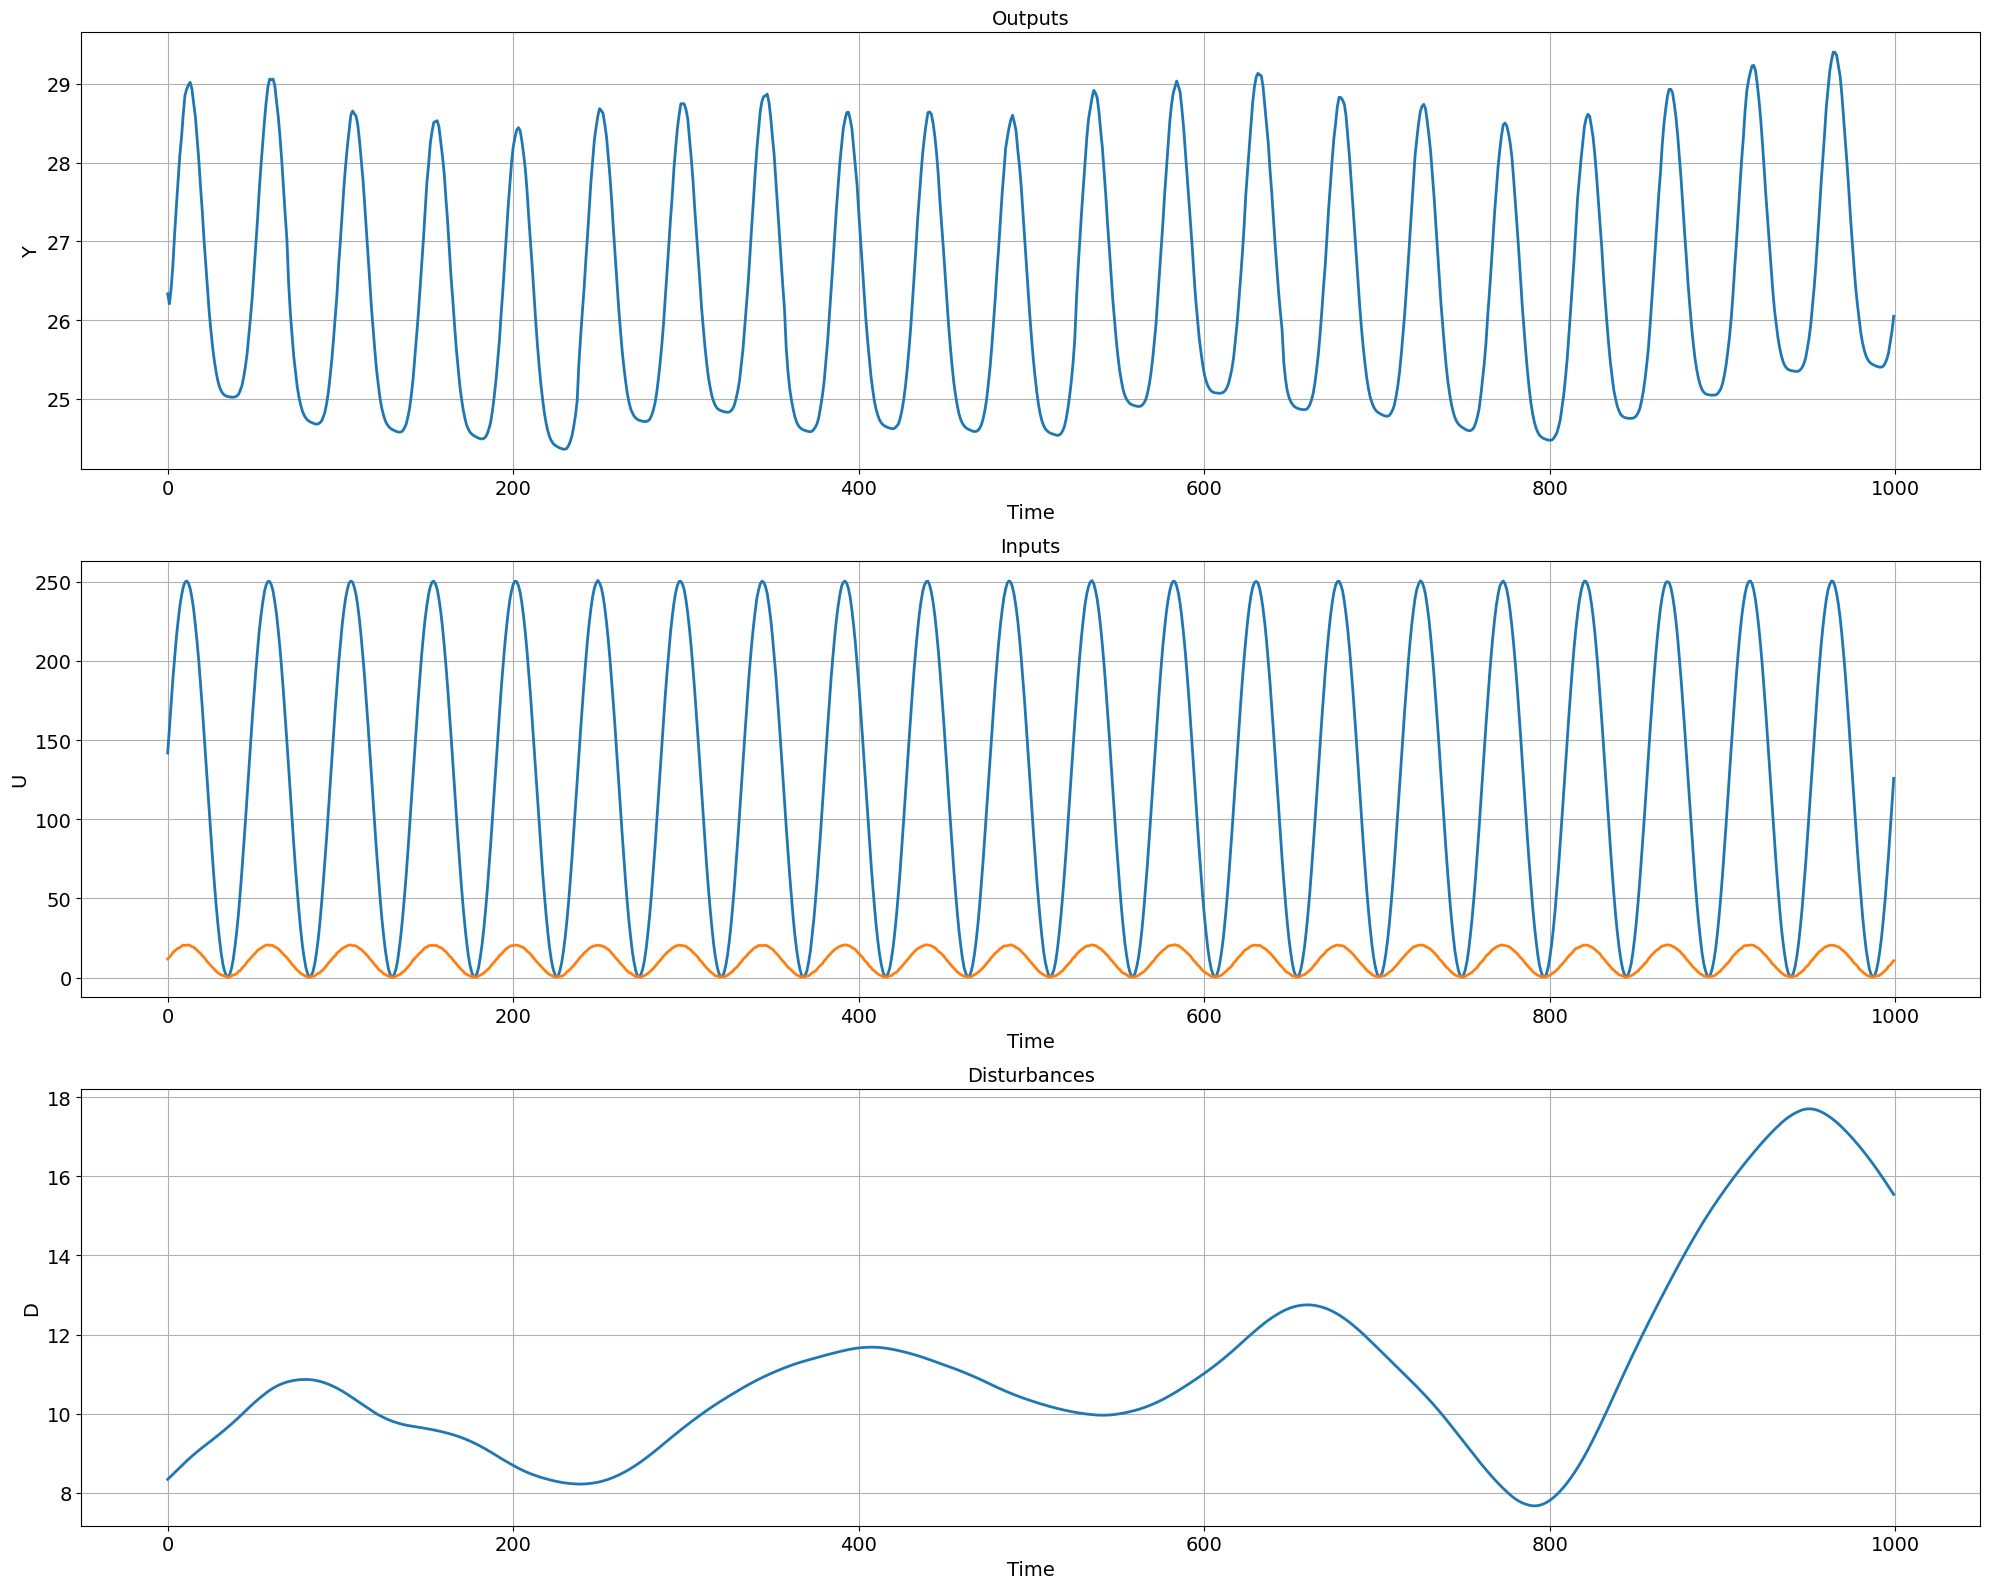

In [39]:
# ground truth system
system_name = "SimpleSingleZone"
system = psl.systems[system_name]
modelSystem = system()
ts = modelSystem.ts
nx = modelSystem.nx
ny = modelSystem.ny
nu = modelSystem.nu
nd = modelSystem.nd
raw = modelSystem.simulate(nsim=1000)
plot.pltOL(Y=raw['Y'], U=raw['U'], D=raw['D'])

## Create training data of sampled trajectories

We will obtain a dataset of sampled trajectories of the system dynamics in the form of input-output-disturbance tuples: 
$$D = \big[(u^i_0, d^i_0, {x}^i_0), ..., (u^i_N,  d^i_N, {x}^i_{N}) \big], \, \, i \in [1, ..., m]$$
where $N$ represents the prediction horizon, $m$ represents number of measured trajectories, and $i$ represents an index of the sampled trajectory.
Variables $x_k$ represent system states, $d_k$ are system disturbances, and $u_k$ are exogenous inputs at time $k$.


In [40]:
def normalize(x, mean, std):
    return (x - mean) / std

def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nu = sys.nu
    nd = sys.nd
    ny = sys.ny
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    mean_x = modelSystem.stats['X']['mean']
    std_x = modelSystem.stats['X']['std']
    mean_y = modelSystem.stats['Y']['mean']
    std_y = modelSystem.stats['Y']['std']
    mean_u = modelSystem.stats['U']['mean']
    std_u = modelSystem.stats['U']['std']
    mean_d = modelSystem.stats['D']['mean']
    std_d = modelSystem.stats['D']['std']

    trainX = normalize(train_sim['X'][:length], mean_x, std_x)
    trainX = trainX.reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainY = normalize(train_sim['Y'][:length], mean_y, std_y)
    trainY = trainY.reshape(nbatch, nsteps, ny)
    trainY = torch.tensor(trainY, dtype=torch.float32)
    trainU = normalize(train_sim['U'][:length], mean_u, std_u)
    trainU = trainU.reshape(nbatch, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    trainD = normalize(train_sim['D'][:length], mean_d, std_d)
    trainD = trainD.reshape(nbatch, nsteps, nd)
    trainD = torch.tensor(trainD, dtype=torch.float32)
    train_data = DictDataset({'X': trainX, 'yn': trainY[:, 0:1, :],
                              'Y': trainY,
                              'U': trainU,
                              'D': trainD}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devX = normalize(dev_sim['X'][:length], mean_x, std_x)
    devX = devX.reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    devY = normalize(dev_sim['Y'][:length], mean_y, std_y)
    devY = devY.reshape(nbatch, nsteps, ny)
    devY = torch.tensor(devY, dtype=torch.float32)
    devU = normalize(dev_sim['U'][:length], mean_u, std_u)
    devU = devU[:length].reshape(nbatch, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    devD = normalize(dev_sim['D'][:length], mean_d, std_d)
    devD = devD[:length].reshape(nbatch, nsteps, nd)
    devD = torch.tensor(devD, dtype=torch.float32)
    dev_data = DictDataset({'X': devX, 'yn': devY[:, 0:1, :],
                            'Y': devY,
                            'U': devU,
                            'D': devD}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testX = normalize(test_sim['X'][:length], mean_x, std_x)
    testX = testX.reshape(1, nbatch*nsteps, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    testY = normalize(test_sim['Y'][:length], mean_y, std_y)
    testY = testY.reshape(1, nbatch*nsteps, ny)
    testY = torch.tensor(testY, dtype=torch.float32)
    testU = normalize(test_sim['U'][:length], mean_u, std_u)
    testU = testU.reshape(1, nbatch * nsteps, nu)
    testU = torch.tensor(testU, dtype=torch.float32)
    testD = normalize(test_sim['D'][:length], mean_d, std_d)
    testD = testD.reshape(1, nbatch*nsteps, nd)
    testD = torch.tensor(testD, dtype=torch.float32)
    test_data = {'X': testX, 'yn': testY[:, 0:1, :],
                 'Y': testY, 'U': testU, 'D': testD,
                 'name': 'test'}

    return train_loader, dev_loader, test_data


In [41]:
nsim = 2000   # number of simulation steps in the dataset
nsteps = 2   # number of prediction horizon steps in the loss function
bs = 100       # minibatching batch size
train_loader, dev_loader, test_data = get_data(modelSystem, nsim, nsteps, ts, bs)

## NSSM system model in Neuromancer

Here we construct a state space model  $x_{k+1} = A_{\theta}(x_k) + B_{\theta}(u_k) +D_{\theta}(d_k)$ with $A$, $B$, $D$ parametrized by neural networks with trainable parameters $\theta$.

In [42]:
class SSM(nn.Module):
    """
    Baseline class for (neural) state space model (SSM)
    Implements discrete-time dynamical system:
        x_k+1 = fx(x_k) + fu(u_k) + fd(d_k)
    with variables:
        x_k - states
        u_k - control inputs
    """
    def __init__(self, fx, fu, fd, nx, nu, nd):
        super().__init__()
        self.fx, self.fu, self.fd = fx, fu, fd
        self.nx, self.nu, self.nd = nx, nu, nd
        self.in_features, self.out_features = nx+nu+nd, nx

    def forward(self, x, u, d):
        """
        :param x: (torch.Tensor, shape=[batchsize, nx])
        :param u: (torch.Tensor, shape=[batchsize, nu])
        :return: (torch.Tensor, shape=[batchsize, outsize])
        """
        # state space model
        x = self.fx(x) + self.fu(u) + self.fd(d)
        return x

In [43]:
n_hidden = 80
n_layers = 2
# instantiate neural nets
fx = blocks.MLP(ny, ny, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=n_layers*[n_hidden])
fu = blocks.MLP(nu, ny, bias=True,
                linear_map=torch.nn.Linear,
                nonlin=torch.nn.ReLU,
                hsizes=n_layers*[n_hidden])
fd = blocks.MLP(nd, ny, bias=True,
                linear_map=torch.nn.Linear,
                nonlin=torch.nn.ReLU,
                hsizes=n_layers*[n_hidden])
# construct NSSM model in Neuromancer
ssm = SSM(fx, fu, fd, ny, nu, nd)

For training we need to obtain accurate reverse-mode gradients by unrolling the operations of the NSSM and using the [backpropagation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time) (BPTT) algorithm. Numner of steps (nsteps) to rollout the NSSM model can be specified in the symbolic System model in Neuromancer.

In [44]:
# construct symbolic model
model = Node(ssm, ['yn', 'U', 'D'], ['yn'], name='NSSM')
dynamics_model = System([model], name='system')

## Define system identification loss function terms

Here we define loss function terms to fit the ODE parameters from given time-series data.

**Tracking loss:**  
$$\ell_x = Q_N||x^i_k - \hat{x}^i_k||_2^2$$ 
**One-step loss:**  
$$\ell_x = Q_1||x^i_1 - \hat{x}^i_1||_2^2$$ 

In [45]:
# %% Constraints + losses:
y = variable("Y")
yhat = variable('yn')[:, :-1, :]

# trajectory tracking loss
reference_loss = 10.*(yhat == y)^2
reference_loss.name = "ref_loss"

# one-step tracking loss
onestep_loss = 1.*(yhat[:, 1, :] == y[:, 1, :])^2
onestep_loss.name = "onestep_loss"

## Construct System ID learning problem

Given the training dataset $D$ we want to solve the following problem:
 
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m \Big(Q_1||x^i_1 - \hat{x}^i_1||_2^2 + \sum_{k=1}^{N}  Q_N||x^i_k - \hat{x}^i_k||_2^2   \Big) \\
&\text{subject to}    &&  x^i_{k+1} = A_{\theta}(x^i_k) + B_{\theta}(u^i_k) +D_{\theta}(d^i_k)
\end{align}
$$  

In [46]:
objectives = [reference_loss, onestep_loss]
constraints = []

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)

# construct constrained optimization problem
problem = Problem([dynamics_model], loss)

# plot computational graph
# problem.show()

## Solve the problem

We fit the unknown model parameters $\theta$ using stochastic gradient descent.

In [47]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=100,
    warmup=100,
    epochs=1000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
)

In [48]:
# Curriculum Model training
iterations = 5
for i in range(iterations):
    print(f'training {nsteps} objective')
    best_model = trainer.train()
    trainer.model.load_state_dict(best_model)
    nsteps *= 2  # increase prediction horizon
    # create dataloaders with batched trajectories using new prediction horizon
    train_loader, dev_loader, test_data = \
        get_data(modelSystem, nsim, nsteps, ts, bs)
    trainer.train_data, trainer.dev_data, trainer.test_data = \
        train_loader, dev_loader, test_data
    # reset early stopping
    trainer.badcount = 0

training 2 objective
epoch: 0  train_loss: 1.041778802871704
epoch: 1  train_loss: 0.18009284138679504
epoch: 2  train_loss: 0.07914222031831741
epoch: 3  train_loss: 0.04294291511178017
epoch: 4  train_loss: 0.02456294372677803
epoch: 5  train_loss: 0.02030428871512413
epoch: 6  train_loss: 0.016889337450265884
epoch: 7  train_loss: 0.015437130816280842
epoch: 8  train_loss: 0.014356689527630806
epoch: 9  train_loss: 0.01321629248559475
epoch: 10  train_loss: 0.012551501393318176
epoch: 11  train_loss: 0.012007955461740494
epoch: 12  train_loss: 0.011628767475485802
epoch: 13  train_loss: 0.011221082881093025
epoch: 14  train_loss: 0.010868174955248833
epoch: 15  train_loss: 0.010661901906132698
epoch: 16  train_loss: 0.010187957435846329
epoch: 17  train_loss: 0.010137723758816719
epoch: 18  train_loss: 0.010048653930425644
epoch: 19  train_loss: 0.009981024079024792
epoch: 20  train_loss: 0.009596415795385838
epoch: 21  train_loss: 0.009416749700903893
epoch: 22  train_loss: 0.00934

epoch: 187  train_loss: 0.008720200508832932
epoch: 188  train_loss: 0.008787425234913826
epoch: 189  train_loss: 0.00872750859707594
epoch: 190  train_loss: 0.009374688379466534
epoch: 191  train_loss: 0.01114042941480875
epoch: 192  train_loss: 0.01053619384765625
epoch: 193  train_loss: 0.009567739441990852
epoch: 194  train_loss: 0.009356969967484474
epoch: 195  train_loss: 0.008950389921665192
epoch: 196  train_loss: 0.008751513436436653
epoch: 197  train_loss: 0.009162451140582561
epoch: 198  train_loss: 0.008711515925824642
epoch: 199  train_loss: 0.009169233031570911
epoch: 200  train_loss: 0.008762190118432045
epoch: 201  train_loss: 0.008728927001357079
Early stopping!!!
training 4 objective
epoch: 201  train_loss: 3.7427475452423096
epoch: 202  train_loss: 1.5230528116226196
epoch: 203  train_loss: 0.8459171056747437
epoch: 204  train_loss: 0.7035033106803894
epoch: 205  train_loss: 0.6058821678161621
epoch: 206  train_loss: 0.4601461887359619
epoch: 207  train_loss: 0.44898

epoch: 372  train_loss: 0.5872268080711365
epoch: 373  train_loss: 0.601525604724884
epoch: 374  train_loss: 0.5953827500343323
epoch: 375  train_loss: 0.5805873870849609
epoch: 376  train_loss: 0.5864048600196838
epoch: 377  train_loss: 0.5830766558647156
epoch: 378  train_loss: 0.5599796175956726
epoch: 379  train_loss: 0.5606659054756165
epoch: 380  train_loss: 0.5585861206054688
epoch: 381  train_loss: 0.5675299763679504
epoch: 382  train_loss: 0.5599521994590759
epoch: 383  train_loss: 0.6063234210014343
epoch: 384  train_loss: 0.5608060359954834
epoch: 385  train_loss: 0.5621764659881592
epoch: 386  train_loss: 0.5702205896377563
epoch: 387  train_loss: 0.5490952134132385
epoch: 388  train_loss: 0.5483858585357666
epoch: 389  train_loss: 0.5471057891845703
epoch: 390  train_loss: 0.5360272526741028
epoch: 391  train_loss: 0.5633589029312134
epoch: 392  train_loss: 0.5985350012779236
epoch: 393  train_loss: 0.540431559085846
epoch: 394  train_loss: 0.5928998589515686
epoch: 395  t

epoch: 561  train_loss: 0.8422348499298096
epoch: 562  train_loss: 0.8413294553756714
epoch: 563  train_loss: 0.8403844833374023
epoch: 564  train_loss: 0.8387134671211243
epoch: 565  train_loss: 0.836274266242981
epoch: 566  train_loss: 0.8335632085800171
epoch: 567  train_loss: 0.8309746384620667
epoch: 568  train_loss: 0.8288344740867615
epoch: 569  train_loss: 0.8273004293441772
epoch: 570  train_loss: 0.8261926174163818
epoch: 571  train_loss: 0.8251510858535767
epoch: 572  train_loss: 0.8238899111747742
epoch: 573  train_loss: 0.8223146796226501
epoch: 574  train_loss: 0.8206146955490112
epoch: 575  train_loss: 0.8189910650253296
epoch: 576  train_loss: 0.817556619644165
epoch: 577  train_loss: 0.8162935376167297
epoch: 578  train_loss: 0.815079927444458
epoch: 579  train_loss: 0.8137884140014648
epoch: 580  train_loss: 0.8123618364334106
epoch: 581  train_loss: 0.810829222202301
epoch: 582  train_loss: 0.8092875480651855
epoch: 583  train_loss: 0.8078286647796631
epoch: 584  tra

## Parameter estimation results

In [49]:
test_outputs = dynamics_model(test_data)

In [50]:
def denormalize(x, mean, std):
    return (x * std) + mean

pred_traj = denormalize(test_outputs['yn'][:, :-1, :].detach().numpy(), modelSystem.stats["Y"]["mean"],
                        modelSystem.stats["Y"]["std"]).reshape(-1, ny).T
true_traj = denormalize(test_data['Y'].detach().numpy(), modelSystem.stats["Y"]["mean"],
                        modelSystem.stats["Y"]["std"]).reshape(-1,ny).T
input_traj = denormalize(test_data['U'].detach().numpy(),
                         modelSystem.stats["U"]["mean"], modelSystem.stats["U"]["std"]).reshape(-1, nu).T
dist_traj = denormalize(test_data['D'].detach().numpy(),
                        modelSystem.stats["D"]["mean"], modelSystem.stats["D"]["std"]).reshape(-1,nd).T

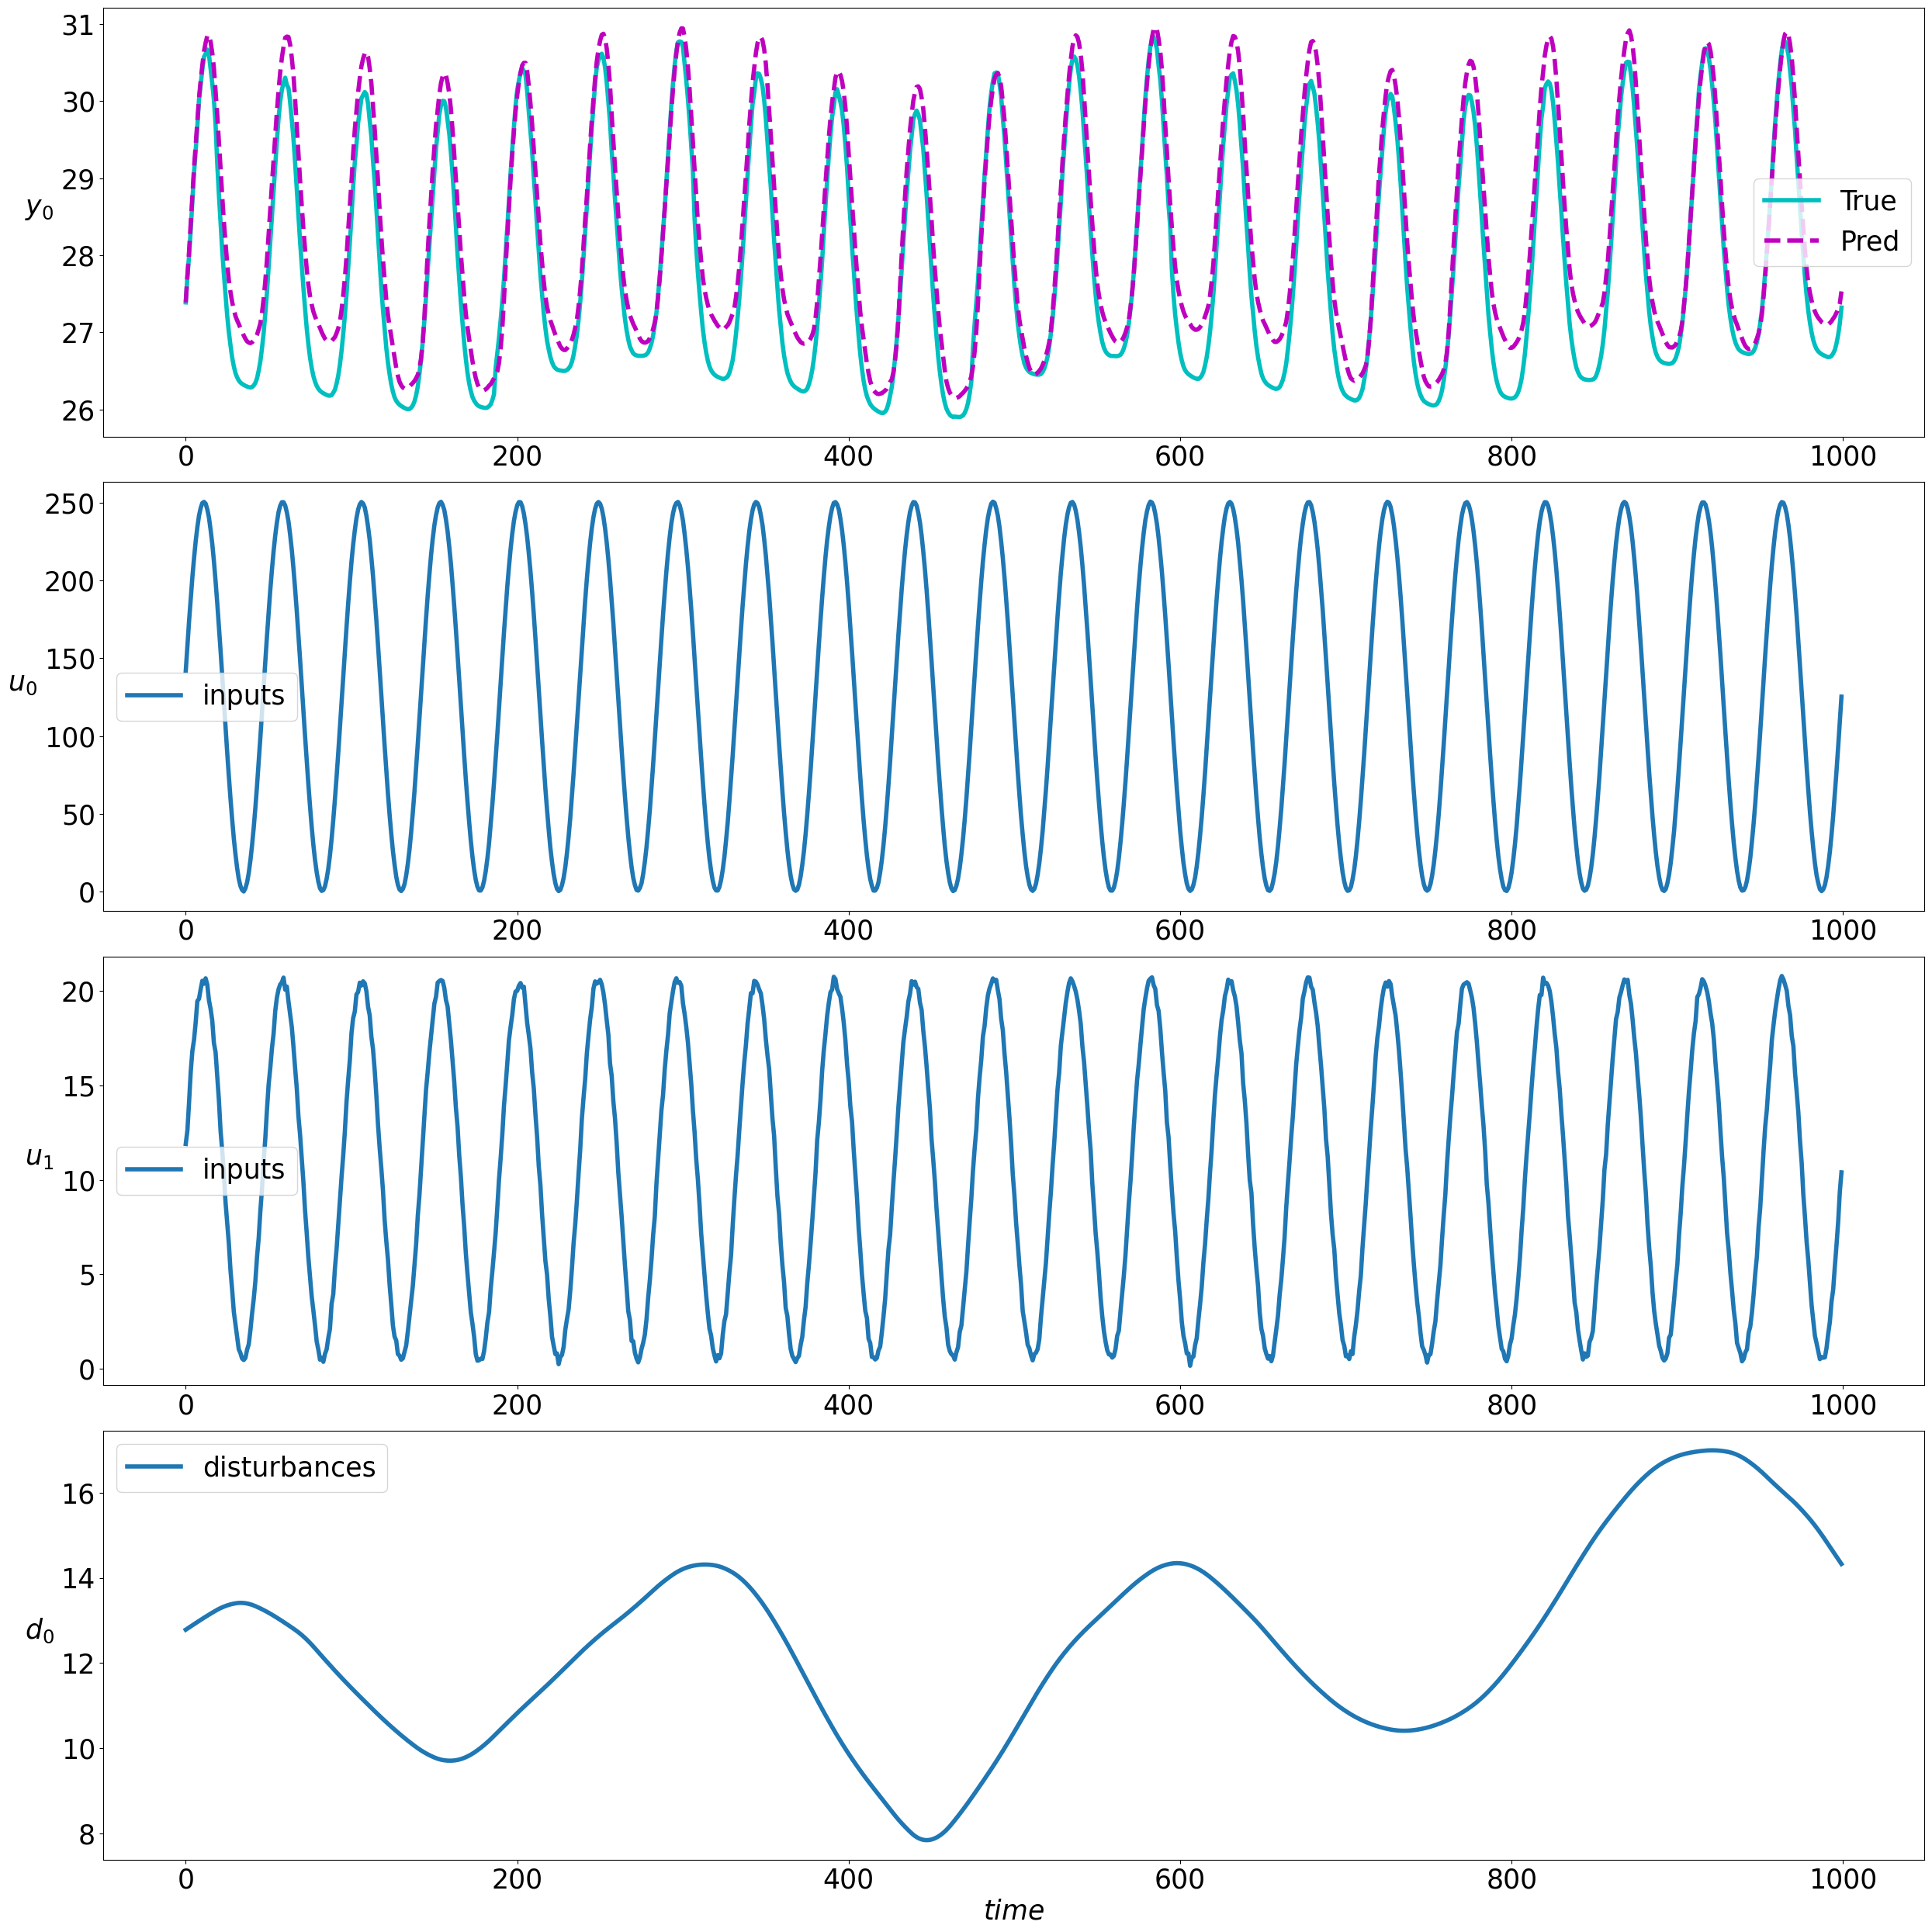

In [51]:
plt_nsteps = 1000

# plot rollout
figsize = 25
fig, ax = plt.subplots(ny + nu + nd, figsize=(figsize, figsize))

x_labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, x_labels)):
    axe = ax[row]
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1[:plt_nsteps], 'c', linewidth=4.0, label='True')
    axe.plot(t2[:plt_nsteps], 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)

u_labels = [f'$u_{k}$' for k in range(len(input_traj))]
for row, (u, label) in enumerate(zip(input_traj, u_labels)):
    axe = ax[row+ny]
    axe.plot(u[:plt_nsteps], linewidth=4.0, label='inputs')
    axe.legend(fontsize=figsize)
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.tick_params(labelbottom=True, labelsize=figsize)

d_labels = [f'$d_{k}$' for k in range(len(dist_traj))]
for row, (d, label) in enumerate(zip(dist_traj, d_labels)):
    axe = ax[row+ny+nu]
    axe.plot(d[:plt_nsteps], linewidth=4.0, label='disturbances')
    axe.legend(fontsize=figsize)
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.tick_params(labelbottom=True, labelsize=figsize)

ax[-1].set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()
